In [1]:
from matplotlib import pyplot as plt
import numpy as np
import astroplan


=== SN 2018ivc @ APO for local night 2025-10-30 ===
ICRS coordinates: RA = 2:42:41.3, Dec = -0:00:31.92
Evening astro twilight end: 2025-10-29 19:37:49 MDT
Morning astro twilight start: 2025-10-30 05:56:24 MDT
Rise (geom.): 2025-10-30 19:08:39 MDT
Transit:       2025-10-30 01:11:52 MDT  (alt=57.3 deg)
Set (geom.):   2025-10-30 07:11:09 MDT
Minimum Moon separation: 81.7° at 2025-10-30 05:55:49 MDT

Apparent RA/Dec (CIRS, 30-min steps):
2025-10-29 19:37:49 MDT   RA=2:42:42.62264022  Dec=0:06:12.93724373  Alt=  5.3°  AM=10.80  MoonSep= 86.6°
2025-10-29 20:07:49 MDT   RA=2:42:42.62269187  Dec=0:06:12.93682404  Alt= 11.6°  AM=4.97  MoonSep= 86.4°
2025-10-29 20:37:49 MDT   RA=2:42:42.62274334  Dec=0:06:12.93639883  Alt= 17.8°  AM=3.26  MoonSep= 86.3°
2025-10-29 21:07:49 MDT   RA=2:42:42.62279464  Dec=0:06:12.935968  Alt= 24.0°  AM=2.46  MoonSep= 86.1°
2025-10-29 21:37:49 MDT   RA=2:42:42.62284577  Dec=0:06:12.93553148  Alt= 29.9°  AM=2.00  MoonSep= 85.9°
2025-10-29 22:07:49 MDT   RA=2:42:42

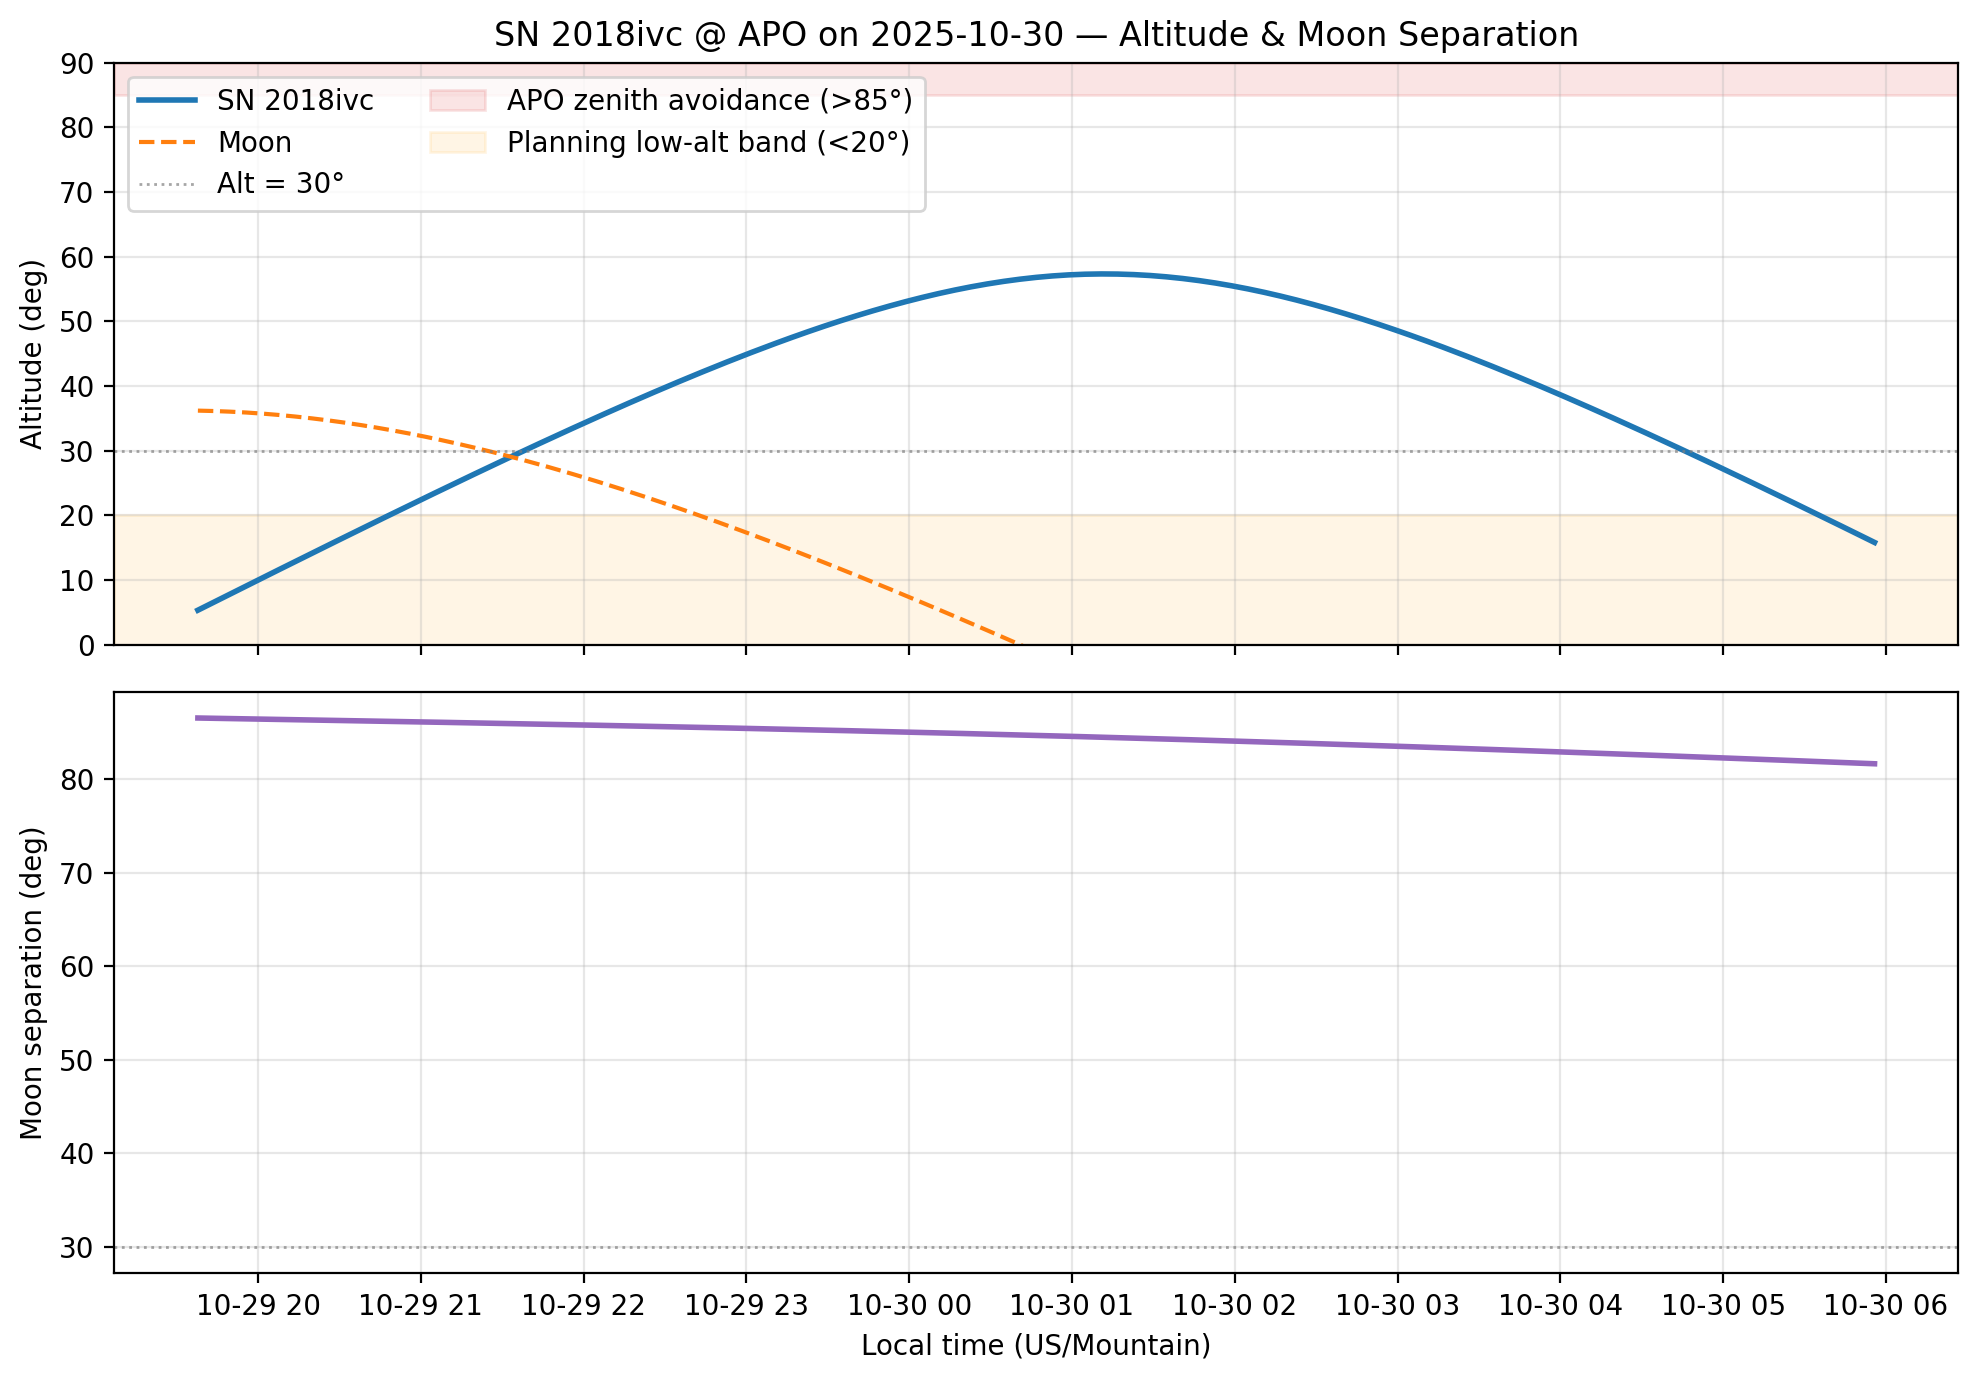

In [8]:
#!/usr/bin/env python3
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import numpy as np
import matplotlib.pyplot as plt

import astropy.units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz, CIRS, get_body
from astroplan import Observer, FixedTarget

# ----------------- Configuration -----------------
target_name = "SN 2018ivc"
# Fixed coordinates (ICRS)
target_coord = SkyCoord("02h42m41.3s", "-00d00m31.92s", frame="icrs")

local_night = "2025-10-30"    # local civil date of the night
time_step_min = 3              # sampling for plots
print_step_min = 30            # print RA/Dec interval
write_csv = True               # output small CSV summary

# Apache Point Observatory (APO)
apo = EarthLocation.from_geodetic(
    lon=-105.8203*u.deg, lat=32.7800*u.deg, height=2790*u.m
)
observer = Observer(location=apo, name="APO", timezone="US/Mountain")
# -------------------------------------------------

target = FixedTarget(coord=target_coord, name=target_name)

# Reference “midnight” and twilight bounds
midnight_local = observer.midnight(Time(local_night), which="nearest")
eve_twilight = observer.twilight_evening_astronomical(midnight_local, which="previous")
morn_twilight = observer.twilight_morning_astronomical(midnight_local, which="next")

# Fallback if twilight not reached
if np.isnan(eve_twilight.jd) or np.isnan(morn_twilight.jd):
    eve_twilight = observer.twilight_evening_nautical(midnight_local, which="previous")
    morn_twilight = observer.twilight_morning_nautical(midnight_local, which="next")

# Rise / set / transit (geometric)
rise_time = observer.target_rise_time(midnight_local, target, which='next', horizon=0*u.deg)
set_time  = observer.target_set_time (midnight_local, target, which='next', horizon=0*u.deg)
transit_time = observer.target_meridian_transit_time(midnight_local, target, which='next')

# Time grid over the dark portion of the night
start_time = eve_twilight if not np.isnan(eve_twilight.jd) else midnight_local - 6*u.hour
end_time   = morn_twilight if not np.isnan(morn_twilight.jd) else midnight_local + 6*u.hour
times = start_time + np.arange(
    0, int((end_time - start_time).to(u.min).value) + 1, time_step_min
) * u.min

# Compute alt/az for target and Moon
altaz_frame = AltAz(obstime=times, location=apo)
altaz_targ = target.coord.transform_to(altaz_frame)
alt_targ = altaz_targ.alt.degree
airmass = altaz_targ.secz.value
airmass[~np.isfinite(airmass)] = np.nan

# --- Use get_body instead of get_moon ---
moon_gcrs = get_body("moon", times, apo)
altaz_moon = moon_gcrs.transform_to(altaz_frame)
alt_moon = altaz_moon.alt.degree

# Angular separation (target–Moon)
sep_moon = altaz_targ.separation(altaz_moon).degree
min_sep_idx = np.nanargmin(sep_moon)
min_sep_time = times[min_sep_idx]
min_sep_val = sep_moon[min_sep_idx]

# Apparent (CIRS) coordinates through the night
cirs_targ = target.coord.transform_to(CIRS(obstime=times))
ra_app = cirs_targ.ra.to(u.hourangle)
dec_app = cirs_targ.dec.to(u.deg)

# Helper for printing
def fmt_time(t):
    return t.to_datetime(timezone=observer.timezone).strftime("%Y-%m-%d %H:%M:%S %Z")

print(f"\n=== {target_name} @ APO for local night {local_night} ===")
print(f"ICRS coordinates: RA = {target.coord.ra.to_string(unit=u.hour, sep=':')}, "
      f"Dec = {target.coord.dec.to_string(unit=u.deg, sep=':')}")
print(f"Evening astro twilight end: {fmt_time(eve_twilight)}")
print(f"Morning astro twilight start: {fmt_time(morn_twilight)}")
print(f"Rise (geom.): {fmt_time(rise_time)}")
print(f"Transit:       {fmt_time(transit_time)}  "
      f"(alt={observer.altaz(transit_time, target).alt.to(u.deg):.1f})")
print(f"Set (geom.):   {fmt_time(set_time)}")
print(f"Minimum Moon separation: {min_sep_val:.1f}° at {fmt_time(min_sep_time)}")

# Print apparent RA/Dec every 30 min
print(f"\nApparent RA/Dec (CIRS, {print_step_min}-min steps):")
step = int(print_step_min / time_step_min)
for k in range(0, len(times), max(step,1)):
    tloc = fmt_time(times[k])
    print(f"{tloc:24s}  RA={ra_app[k].to_string(unit=u.hour, sep=':'):>12s}  "
          f"Dec={dec_app[k].to_string(unit=u.deg, sep=':'):>12s}  "
          f"Alt={alt_targ[k]:5.1f}°  AM={airmass[k]:4.2f}  MoonSep={sep_moon[k]:5.1f}°")

# Optional CSV
if write_csv:
    import csv
    fn_csv = f"{target_name.replace(' ','_')}_APO_{local_night}_summary.csv"
    with open(fn_csv, "w", newline="") as f:
        w = csv.writer(f)
        w.writerow(["local_time","RA_app_hms","Dec_app_dms","alt_deg","airmass","moon_alt_deg","moon_sep_deg"])
        for k in range(len(times)):
            w.writerow([
                fmt_time(times[k]),
                ra_app[k].to_string(unit=u.hour, sep=':'),
                dec_app[k].to_string(unit=u.deg, sep=':'),
                f"{alt_targ[k]:.3f}",
                f"{airmass[k]:.3f}" if np.isfinite(airmass[k]) else "",
                f"{alt_moon[k]:.3f}",
                f"{sep_moon[k]:.3f}"
            ])
    print(f"\nSaved CSV: {fn_csv}")

# ----------- Plot Altitude and Moon Separation with APO limits -----------
tloc = [ti.to_datetime(timezone=observer.timezone) for ti in times]
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 7), sharex=True, dpi=200)

# --- APO altitude constraints ---
APO_ZENITH_AVOID = 85.0   # hard limit: telescope cannot track/slew above this
PLAN_MIN_ALT = 20.0       # planning cutoff (user choice; not a hard limit)

# Altitude: target + Moon
ax1.plot(tloc, alt_targ, lw=2, label=f"{target_name}")
ax1.plot(tloc, alt_moon, lw=1.5, ls='--', label="Moon")

# Reference lines
ax1.axhline(30, color='gray', lw=1, ls=':', alpha=0.7, label="Alt = 30°")

# Shaded forbidden/avoidance regions
ax1.axhspan(APO_ZENITH_AVOID, 90, color='tab:red', alpha=0.12,
            label=f"APO zenith avoidance (>{APO_ZENITH_AVOID:.0f}°)")
ax1.axhspan(0, PLAN_MIN_ALT, color='orange', alpha=0.10,
            label=f"Planning low-alt band (<{PLAN_MIN_ALT:.0f}°)")

ax1.set_ylabel("Altitude (deg)")
ax1.set_ylim(0, 90)
ax1.grid(True, alpha=0.3)
ax1.legend(loc="upper left", ncol=2)
ax1.set_title(f"{target_name} @ APO on {local_night} — Altitude & Moon Separation")

# Moon separation
ax2.plot(tloc, sep_moon, lw=2, color='tab:purple')
ax2.axhline(30, color='gray', lw=1, ls=':', alpha=0.7)
ax2.set_ylabel("Moon separation (deg)")
ax2.set_xlabel(f"Local time ({observer.timezone})")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
png_name = f"{target_name.replace(' ','_')}_APO_{local_night}_alt_and_moon.png"
plt.savefig(png_name, dpi=160)
print(f"Saved plot: {png_name}\n")